# EMI 2024 
## Escuela (de verano) en Métodos Iterativos

- The motivation

  3D simulations, HPC

- The actual motivation

  Upscale simulations, black-box never works

# The only requirement: Weak formulations

$$ -\Delta u = f \quad \Leftrightarrow \quad \int \nabla u \cdot \nabla v\,dx = \int f v\,dx \quad \forall v \in V_0$$

# Motivation problem: CFD

$$ \begin{aligned}-\Delta u + \nabla p = f\\ \mathrm{div}\, u = 0\end{aligned} \Leftrightarrow \begin{aligned}\int \nabla u\cdot \nabla v\,dx + \int p\, \mathrm{div}\, v\,dx && \forall v\in V \\ \int q \,\mathrm{div}\, u \,dx = 0 &&\forall q \in Q \end{aligned} \Leftrightarrow \begin{bmatrix} \mathbf{A} & \mathbf{B}^T \\ \mathbf{B} & \mathbf{0} \end{bmatrix}\begin{bmatrix} \mathbf{U} \\ \mathbf{P} \end{bmatrix} = \begin{bmatrix} \mathbf{F} \\ \mathbf{0} \end{bmatrix}$$

# Import and Geometry

In [22]:
from ngsolve import *
from ngsolve.krylovspace import GMResSolver
from ngsolve.webgui import Draw
from netgen.occ import *

shape = Rectangle(2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape.edges.name="wall"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
Draw (shape);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [23]:
geo = OCCGeometry(shape, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.05))
mesh.Curve(3)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [29]:
V = VectorH1(mesh, order=1, dirichlet="wall|inlet|cyl")
Q = H1(mesh, order=1)
X = V*Q
(u,p),(v,q) = X.TnT()

stokes = InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx - div(v)*p*dx
#stokes = InnerProduct(Grad(u), Grad(v))*dx
a = BilinearForm(stokes).assemble()
f = LinearForm(v[0]*dx)
gf = GridFunction(X)
gfu, gfp = gf.components

uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
#uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
#gf.Set(uin, definedon=mesh.Boundaries("inlet"))
Draw(gfu, mesh, min=0, max=2)
SetVisualization(max=2)


#pre = Preconditioner(a, "local")
#a.Assemble()
#f.Assemble()
#res = f.vec -a.mat * gf.vec
#inv = CGSolver(a.mat, pre.mat, precision=1e-6, printrates=True)
#GMResSolver(A=a.mat, pre=pre.mat, b=gf.vec, tol=1e-6, printrates=True, x=u.vec)
inv = a.mat.Inverse(freedofs=V.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
#gf.vec.data += a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky") * res
Draw(gf)

AttributeError: 'ngsolve.comp.BilinearForm' object has no attribute 'assemble'

Number of non-zeros of A: 2976
Number of non-zeros of L: 4996
Number of non-zeros of U: 4996


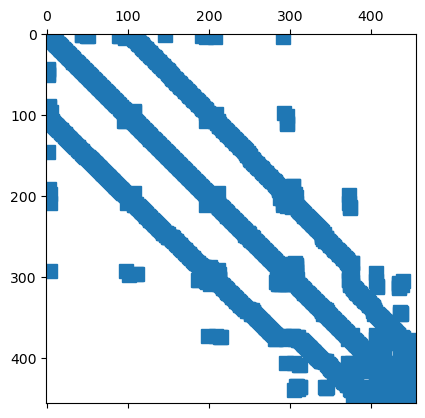

In [21]:
# Now we compute the nonzeros in the LU factorization

rows,cols,vals = a.mat.COO()
print("Number of non-zeros of A:", len(vals))

import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))
from scipy.sparse.linalg import splu # Sparse LU

LU= splu(A)
print("Number of non-zeros of L:", LU.L.nnz)
print("Number of non-zeros of U:", LU.U.nnz)
import matplotlib.pylab as plt
plt.spy(A)
plt.show()


In [19]:
LU.L.nnz

4996

In [ ]:
GM